In [7]:
import os
import numpy as np
from utils import *
import matplotlib.pyplot as plt
import pickle
import random
from fastdtw import fastdtw
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances

import torch
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import scipy.sparse as spp
import dgl
from dgl.nn import EdgeWeightNorm, GraphConv

random_seed = 0
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)
    
P = 10
Q = 5
num_epochs = 500


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_path = "US_State/v1/"
model_path = data_path+"mdl3/"
if not os.path.exists(model_path):
    os.makedirs(model_path)
save_path = model_path+"mdl3_%d.pt"%(P)


f = open(data_path+"scaler.pickle","rb")
scaler = pickle.load(f)
f.close()

f = open(data_path+"features.pickle","rb")
features = pickle.load(f)
f.close()


len_train, len_val = 80, 100

torch.float32


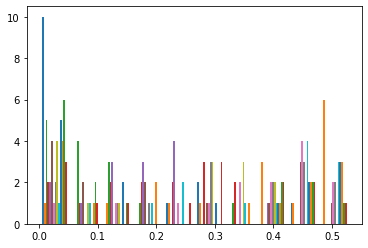

In [8]:
def normalize_row(x):
    for i in range(x.shape[0]):
        x[i,:] = x[i,:]/np.sum(x[i,:])
    return x
def construct_static_graph(xs):
    num_loc = xs.shape[0]
    lamb = 0.5
    ## 距离图
    d = xs[:,:,0] 
    d = np.exp(-(d**2)/(np.std(d)**2))
    
    ## 人口
    p = xs[:,:,1]
    p = np.exp(-(p**2)/(np.std(p)**2))
    
    adj = lamb*d+(1-lamb)*p
    np.fill_diagonal(adj,0)
    plt.hist(adj)
    mask = adj > 0.2
    adj[mask] = 0
    
    return normalize_row(adj)+np.identity(num_loc)
xs = features["xs"]
adj = construct_static_graph(xs)
adj = spp.csr_matrix(adj)

Gs = dgl.from_scipy(adj,'static').to(device)
Gs.edata['static'] = Gs.edata['static'].type(torch.FloatTensor).to(device)
print(Gs.edata['static'].dtype)

In [9]:
def splitDataset(data): # (T,n,in_dim)
    x, y = [],[]
    # xi
    l = data.shape[0]
    for i in range(l-P-Q+1):
        x.append(data[i:i+Q,:,:])
        y.append(data[i+Q+P-1,:,0])
    # print(np.array(x).shape,np.array(y).shape)
    return np.array(x),np.array(y)

xi, xm = features["xi"][:,:,2][:,:,np.newaxis], features["xm"]    
xi,xm = xi.transpose((1,0,2)),xm.transpose((1,0,2))
data = np.concatenate((xi,xm),axis=2)

train,val,test = data[:len_train],data[len_train:len_val],data[len_val:]

train_x,train_y = splitDataset(train)
val_x,val_y = splitDataset(val)
test_x,test_y = splitDataset(test)

train_x,train_y,val_x,val_y,test_x,test_y = torch.tensor(train_x).float().to(device),\
                                            torch.tensor(train_y).float().to(device),\
                                            torch.tensor(val_x).float().to(device),\
                                            torch.tensor(val_y).float().to(device),\
                                            torch.tensor(test_x).float().to(device),\
                                            torch.tensor(test_y).float().to(device)
                                                         
train_set = torch.utils.data.TensorDataset(train_x, train_y)
val_set = torch.utils.data.TensorDataset(val_x, val_y)
test_set = torch.utils.data.TensorDataset(test_x, test_y)
train_iter = DataLoader(train_set,batch_size=20,shuffle=True,drop_last=False)
val_iter = DataLoader(train_set,batch_size=20,shuffle=False,drop_last=False)
test_iter = DataLoader(train_set,batch_size=20,shuffle=False,drop_last=False)
# for x,y in train_iter:
#     print(x.shape,y.shape)
#     break

In [10]:
class mdl3(nn.Module):
    
    def series_similarity(a,b): #(b,n,T)
        sim = torch.zeros(self.num_loc,self.num_loc).to(a.device)
        for i in range(self.num_loc):
            for j in range(i+1,self.num_loc):
                sim[i][j] = F.cosine_similarity(a[i,:],b[j,:])
                sim[j][i] = sim[i][j]
        return sim
        
    def __init__(self,args):
        super(mdl3,self).__init__()
        self.hidS = args['hidS']
        self.m = args['m']
        self.hidC = args['hidC']
        self.hidR = args['hidR']
        self.Q = args['Q']
        self.Ck = 3
        self.w = args['w']
        self.dropout = nn.Dropout(p = args['dropout'])
        
        self.norm = EdgeWeightNorm(norm='both')
        self.GCN = GraphConv(self.Q, self.hidS, norm='none', weight=True, bias=True)
        self.fc1 = nn.Linear(self.hidS,1)
        
        self.conv1 = nn.Conv2d(1,self.hidC,kernel_size =(self.Ck,self.m)) # 在时间维度上卷积
        self.GRU = nn.GRU(self.hidC,self.hidR,batch_first=True)
        self.fc2 = nn.Linear(self.hidR,self.m)
        
        
        # self.ar = nn.Linear(self.w,1)
        
    '''
    x -> (batch_size,Q,n,in_dim)
    Gs -> (n,n)
    
    #Gd -> (batch_size,n,n,in_dim) elsement-wise sum up - > (batch_size,n,n)
    
    Gs
   
    '''
    def forward(self,Gs,x):
        xi = x[:,:,:,0]
        batch_size,T = x.shape[0],x.shape[1]
        spat = torch.zeros(batch_size,self.m,self.hidS).to(x.device)
        for b in range(batch_size):
            norm_weights = Gs.edata['static']
            feats = xi[b,:,:].permute(1,0)
            spat[b,:,:] = self.GCN(Gs,feats,edge_weight=norm_weights)
        spat = self.dropout(spat)
        s = self.fc1(spat).squeeze()
        

        c = xi.view(-1, 1, self.Q, self.m)
        c = F.relu(self.conv1(c))
        c = self.dropout(c)
        c = torch.squeeze(c, 3)
        
        r = c.permute( 0,2,1).contiguous()
        # print(r.shape)
        _,r = self.GRU(r)
        r = self.dropout(torch.squeeze(r,0))
        # print(r.shape)
        res = self.fc2(r)
        # print(res.shape)
        

        # a = xi[:,-self.w:,:].permute(0,2,1)
        # a = self.ar(a).squeeze()
        
        return res+s
        return res+a+s #(b,m)    
        
args = {'hidS':64,'m':xs.shape[0],'hidC':64,'hidR':64,'dropout':0.2,'Q':Q,'w':3}
model = mdl3(args).to(device)



optimizer = optim.Adam(model.parameters(),lr=0.001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.7)
early_stopping = EarlyStopping(save_path=save_path,patience=10, verbose=True)
loss=nn.MSELoss()


In [11]:
min_val_loss = np.inf
for epoch in range(num_epochs):
    l_sum, n = 0.0,0
    model.train()
    for x,y in train_iter:
        y_pred = model(Gs,x).view(-1)
        l = loss(y_pred,y.view(-1))
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        l_sum += l.item()*y.shape[0]
        n += y.shape[0]
    val_loss = evaluate_model(model,val_iter,scaler,method="mdl3",isprint=False,retMetrics="MAE",graph = Gs)
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print ("early stopping")
        break
    # if val_loss < min_val_loss:
    #     min_val_loss = val_loss
    #     torch.save(model.state_dict(),save_path)

Validation loss decreased (inf --> 1493.951773).  Saving model ...
Validation loss decreased (1493.951773 --> 909.824065).  Saving model ...
Validation loss decreased (909.824065 --> 836.119046).  Saving model ...
Validation loss decreased (836.119046 --> 643.162448).  Saving model ...
Validation loss decreased (643.162448 --> 594.188878).  Saving model ...
Validation loss decreased (594.188878 --> 563.485498).  Saving model ...
Validation loss decreased (563.485498 --> 530.061042).  Saving model ...
Validation loss decreased (530.061042 --> 498.553042).  Saving model ...
Validation loss decreased (498.553042 --> 483.696547).  Saving model ...
Validation loss decreased (483.696547 --> 466.364868).  Saving model ...
Validation loss decreased (466.364868 --> 438.823053).  Saving model ...
Validation loss decreased (438.823053 --> 414.047040).  Saving model ...
Validation loss decreased (414.047040 --> 395.820789).  Saving model ...
Validation loss decreased (395.820789 --> 382.956960).  

In [12]:
best_model = mdl3(args).to(device)
best_model.load_state_dict(torch.load(save_path))
y_true,y_pred = evaluate_model(best_model,test_iter,scaler,method="mdl3",isprint=True,retRes=True,graph=Gs)

=========mdl3=========
RMSE	 407.940432
MAE	 249.626120
MAPE	 22.401349
SMAPE	 24.026894
Corr	 0.953204
CCC	 0.949384
